In [1]:
import sys
# Add the src directory to the Python path
sys.path.insert(0, '../src')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from botcoin.profilers.stock import StockProfiler

In [3]:
profiler = StockProfiler()

In [4]:
symbols = ['BRK-B', 'COIN', 'MCD', 'HP', 'MSFT', 'T', 'NVDA']

In [5]:
correlation_matrix = profiler.compute_1d_return_correlation_matrix(symbols)

2025-06-28 22:53:17,827 - DataManager - WARNING: The start date 2020-06-29 is before the IPO date 2021-04-14 for COIN. Adjusting start date to the IPO date.
2025-06-28 22:53:18,081 - YfDataProvider - WARNING: Negative IPO date milliseconds for MCD, returning the earliest available date.
2025-06-28 22:53:19,718 - DataManager - WARNING: The start date 2020-06-29 is before the IPO date 2021-04-14 for COIN. Adjusting start date to the IPO date.
2025-06-28 22:53:19,721 - YfDataProvider - WARNING: Negative IPO date milliseconds for MCD, returning the earliest available date.
2025-06-28 22:53:20,214 - DataManager - WARNING: The start date 2020-06-29 is before the IPO date 2021-04-14 for COIN. Adjusting start date to the IPO date.
2025-06-28 22:53:20,221 - DataManager - WARNING: The start date 2020-06-29 is before the IPO date 2021-04-14 for COIN. Adjusting start date to the IPO date.
2025-06-28 22:53:20,227 - DataManager - WARNING: The start date 2020-06-29 is before the IPO date 2021-04-14 f

In [6]:
correlation_matrix = correlation_matrix.astype(float)
correlation_matrix

,BRK-B,COIN,MCD,HP,MSFT,T,NVDA
BRK-B,1.000000,0.242187,0.410647,0.376215,0.388023,0.416488,0.249899
COIN,0.242187,1.000000,0.098682,0.183101,0.466726,0.107030,0.500339
MCD,0.410647,0.098682,1.000000,0.121807,0.314490,0.290222,0.195783
HP,0.376215,0.183101,0.121807,1.000000,0.118767,0.203510,0.174805
MSFT,0.388023,0.466726,0.314490,0.118767,1.000000,0.123624,0.648237
T,0.416488,0.107030,0.290222,0.203510,0.123624,1.000000,0.008282
NVDA,0.249899,0.500339,0.195783,0.174805,0.648237,0.008282,1.000000


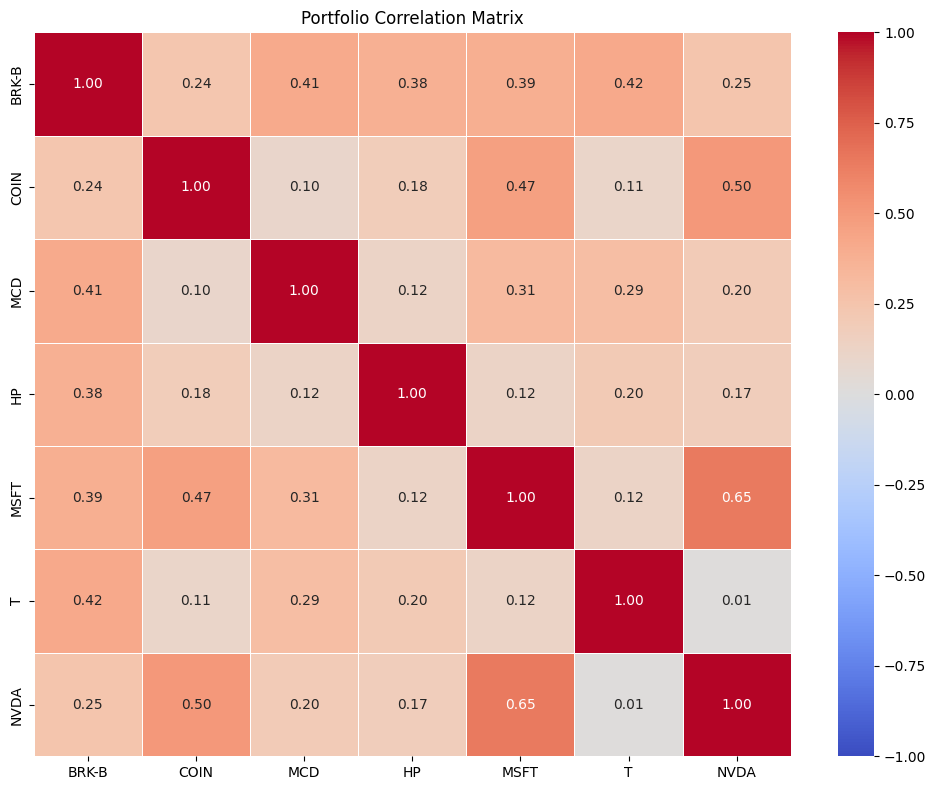

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,       # Show values in cells
            cmap='coolwarm',  # Color palette
            vmin=-1, vmax=1,  # Set range for correlation values
            linewidths=0.5,   # Grid lines
            fmt=".2f")        # Format numbers to 2 decimals
plt.title("Portfolio Correlation Matrix")
plt.tight_layout()
plt.show()


## PCA for Portfolio Analysis
PCA (Principal Component Analysis) is a powerful tool for analyzing correlation structures in a portfolio. It helps uncover how many unique sources of risk or diversification exist among your assets.

### What is PCA in the Context of Correlation Matrices?
PCA decomposes your correlation matrix into orthogonal components (directions) that explain the variance in the system. These are called principal components (PCs).

For a correlation matrix:
- First principal component = direction of maximum shared movement.
- Subsequent components = uncorrelated patterns of variation.
- The explained variance ratio tells you how much of the total market movement is explained by each component.

## 🧮 Mathematically

Given a correlation matrix $\mathbf{C}$, PCA finds eigenvalues $\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_n$ and eigenvectors $v_1, v_2, \dots, v_n$ such that:

\begin{equation}
\mathbf{C} v_i = \lambda_i v_i
\end{equation}

Where:

- $\lambda_i $ tells you **how much variance** is explained by the $i^\text{th}$ component.
- Total variance = sum of all $ \lambda_i $ = number of assets (if using a correlation matrix).


In [8]:
# Apply PCA on correlation matrix
pca = PCA()
pca.fit(correlation_matrix)

# Explained variance ratios
explained = pca.explained_variance_ratio_

# Print top components
for i, var in enumerate(explained[:5]):
    print(f"PC{i+1}: {var:.2%} of variance")

PC1: 49.70% of variance
PC2: 21.49% of variance
PC3: 12.33% of variance
PC4: 8.36% of variance
PC5: 5.74% of variance


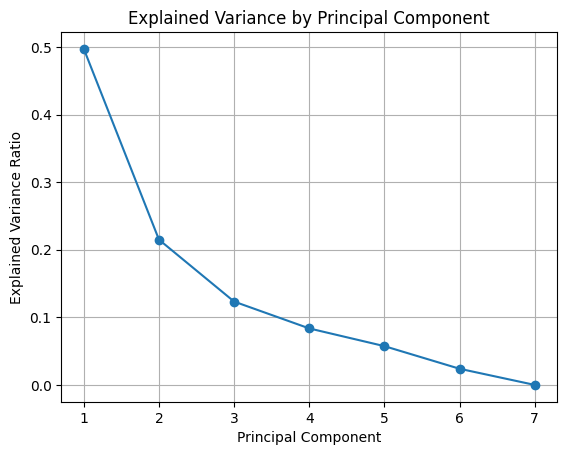

In [9]:
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

| Metric            | Meaning                                                |
| ----------------- | ------------------------------------------------------ |
| **PC1 \~ 70–90%** | Most assets are moving together. Poor diversification. |
| **PC1 \~ 40–60%** | Some dominant trend, but some diversification.         |
| **PC1 < 30%**     | Well diversified — many independent sources of return. |


- PC1 might represent "market risk" — the movement of all stocks together.

- PC2/PC3 might represent sector risks (e.g., tech vs. consumer).